# Credit Card Fraud Detection (Class imbalance problem)

* The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

* It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.**



In [1]:
#Primary dependencies 
import pandas as pd 
import numpy as np 
import sklearn as sk 
import matplotlib.pyplot as plt 
import seaborn as sns 
import imblearn as imb 

#Secondary dependencies
import random 
import itertools as it
import scipy 
import math


In [2]:
#Data 
df = pd.read_csv('/home/sauraj/Desktop/Fraud/creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

*Time, Amount* and *Class* features are the only numeric features which have been provided without PCA decomposition. The rest of the features have been transformed through PCA in the dataset.

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Class Distribution of the dataset 

Text(0.5, 1.0, 'Class Distribution')

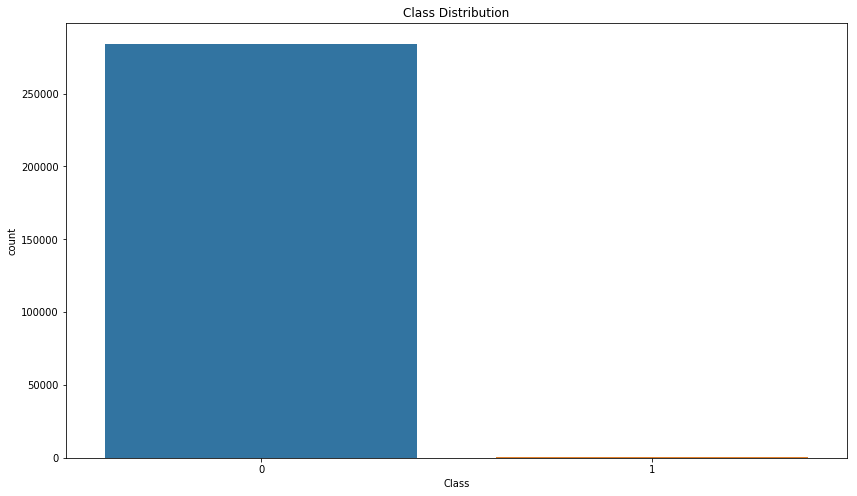

In [4]:
plt.figure(figsize=(14,8))
sns.countplot(df['Class'])
plt.title('Class Distribution')

In [5]:
len(df['Class'].loc[df['Class'] == 1] )

492

Here is gets quite obvious that the dataset we are working on has a huge class imbalance

In [6]:
#Let's check the class imbalance 

def class_imbalance_check(df_col):
    class_0_len = len(df['Class'].loc[df['Class'] == 0])
    class_1_len = len(df['Class'].loc[df['Class'] == 1])
    
    print('-------------------------------------------')
    print('Class 0 count: {}'.format(class_0_len))
    print('\nClass 1 count: {}'.format(class_1_len))
    print('\n % of fraudulent transactions: {}'.format((class_1_len/len(df))*100))
    print('-------------------------------------------')
    

In [7]:
class_imbalance_check(df['Class'])

-------------------------------------------
Class 0 count: 284315

Class 1 count: 492

 % of fraudulent transactions: 0.1727485630620034
-------------------------------------------


The class imbalance makes this a problem of undersampling since 492 points are only there for actual fraud transactions which occured in the whole of dataset. This will require a resampling technique to make sure that the classes are balanced properly.

Text(0.5, 1.0, 'Non-Fraud Transcations and the amounts involved')

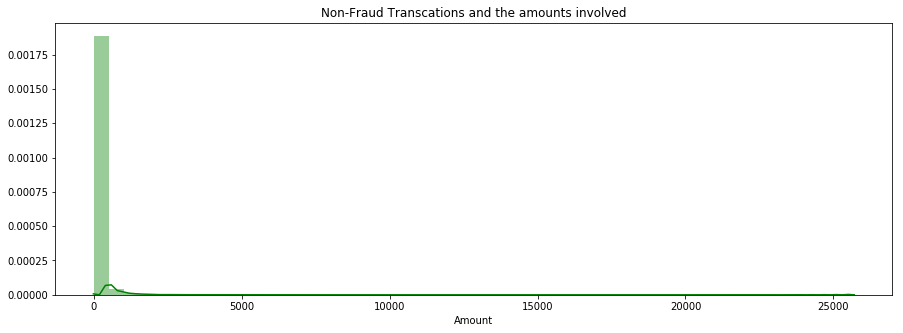

In [8]:
amt_0 = df['Amount'].loc[df['Class'] == 0]
amt_1 = df['Amount'].loc[df['Class'] == 1]

plt.figure(figsize=(15,5))
sns.distplot(amt_0, color='green')
plt.title('Non-Fraud Transcations and the amounts involved')

Text(0.5, 1.0, 'Fraud Transcations and the amounts involved')

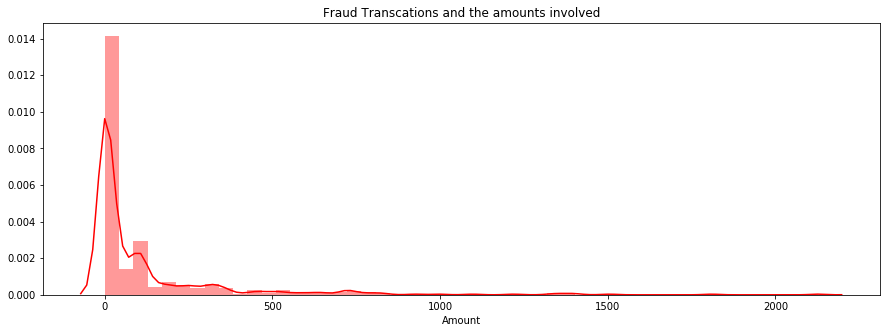

In [9]:
plt.figure(figsize=(15,5))
sns.distplot(amt_1, color='red')
plt.title('Fraud Transcations and the amounts involved')

Text(0.5, 1.0, 'Non-Fraud Transcations and the time involved between transcations')

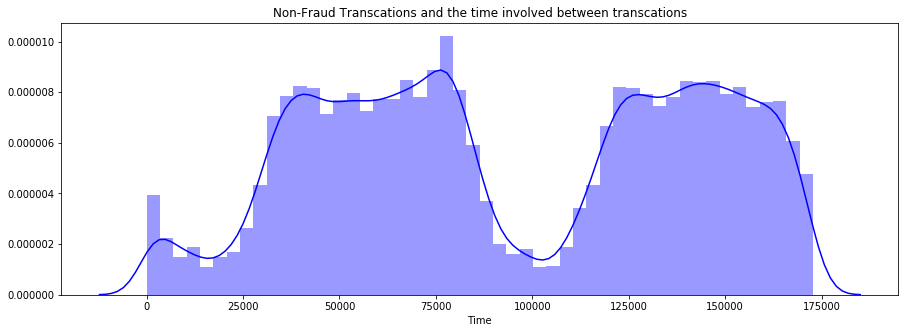

In [10]:
plt.figure(figsize=(15,5))
sns.distplot(df['Time'].loc[df['Class'] == 0], color='blue')
plt.title('Non-Fraud Transcations and the time involved between transcations')

Text(0.5, 1.0, 'Fraud Transcations and the time involved between transcations')

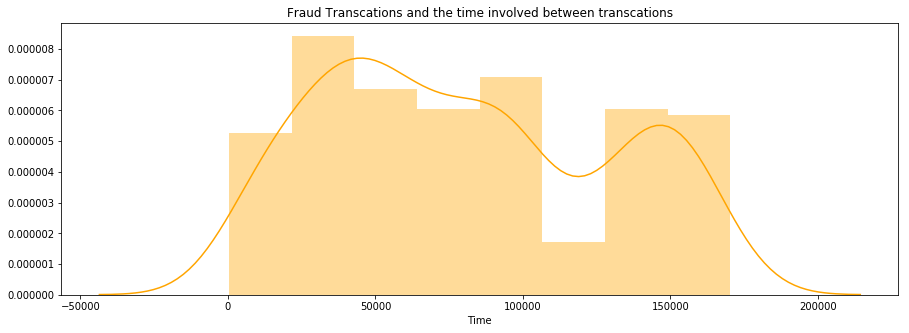

In [11]:
plt.figure(figsize=(15,5))
sns.distplot(df['Time'].loc[df['Class'] == 1], color='orange')
plt.title('Fraud Transcations and the time involved between transcations')

### Scaling Time and Amount features using normalization to make all features have similar properties

In [12]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

df['Time_scaled'] = rs.fit_transform(df['Time'].values.reshape(-1,1))
df['Amt_scaled'] = rs.fit_transform(df['Amount'].values.reshape(-1, 1))

df = df.drop(['Time', 'Amount'], axis=1)
df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_scaled,Amt_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.994983,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.994983,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-0.994972,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.994972,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.994960,0.670579


## Undersampling and Oversampling; Class Imbalance Issue 

* Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set (i.e. the ratio between the different classes/categories represented). These terms are used both in statistical sampling, survey design methodology and in machine learning.

* Both oversampling and undersampling involve introducing a bias to select more samples from one class than from another, to compensate for an imbalance that is either already present in the data, or likely to develop if a purely random sample were taken.


### To start the training process, the data will have to be split in such a manner so as to ensure that the training set is a true representation of the actual fraud data which is generated during bank transcations. This will require stratification of the dataset in such a way that the class imbalance is carried equally in both the training and the testing set so as to preserve the underlying distribution of the data.

In [13]:
#StratifiedShuffleSplit retains the same proportion of Xs and Y in both the partitions
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(['Class'], axis=1)
y = df['Class']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=44)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    

    
#Is the test data having a similar distribution as that of the training data?

print('--------------------------------------------------------------')
print('% of non-fraud class in training set: {}'.format((len(original_ytrain.loc[original_ytrain == 0])/len(original_ytrain))*100))
print('% of fraud class in the training set: {}'.format((len(original_ytrain.loc[original_ytrain == 1])/len(original_ytrain))*100))
print('\n% of non-fraud class in test set: {}'.format((len(original_ytest.loc[original_ytest == 0])/len(original_ytest))*100))
print('% of fraud class in the test set: {}'.format((len(original_ytest.loc[original_ytest == 1])/len(original_ytest))*100))
print('---------------------------------------------------------------')

--------------------------------------------------------------
% of non-fraud class in training set: 99.82707542408215
% of fraud class in the training set: 0.17292457591783889

% of non-fraud class in test set: 99.82795547909133
% of fraud class in the test set: 0.17204452090867595
---------------------------------------------------------------


## Data Visualization through Clustering; T-Stochastic Neighbor Embedding [TSNE]

In [ ]:
from sklearn.manifold import TSNE

X_Tsne = TSNE(n_components=2).fit_transform(X)

## Random Undersampling of the dataset 

In [14]:
#Create 2 separate dataframes, one for non fraud and the other for fraud 

new_df = df[df['Class'] == 1]
df_0class = df[df['Class'] == 0]

sample_df0class = df_0class.sample(492)

new_df = pd.concat([new_df, sample_df0class])

Text(0.5, 1.0, 'Class balance after random undersampling')

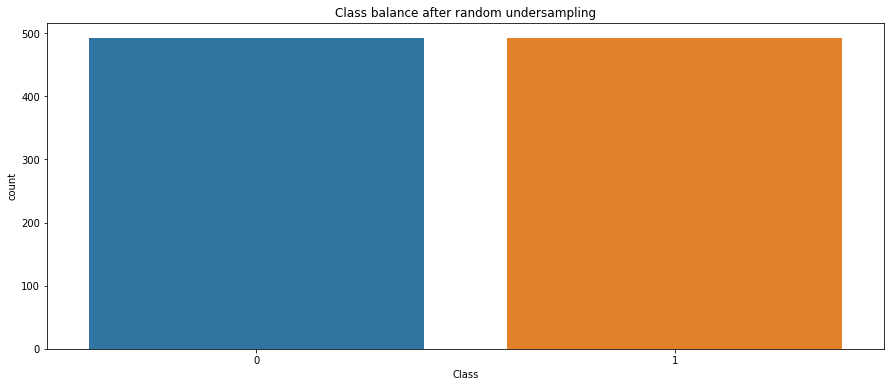

In [15]:
plt.figure(figsize=(15, 6))
sns.countplot(new_df['Class'])
plt.title('Class balance after random undersampling')

## Model fitting for Undersample Data

Now that the data has been undersampled, the next thing to do is to fit learning models on this newly undersampled data

In [16]:
#Undersampled data features 

X_usmpl = new_df.drop(['Class'], axis=1)
y_usmpl = new_df['Class']

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Cross-validation on undersampled dataset

X_train, X_test, y_train, y_test = train_test_split(X_usmpl, y_usmpl, test_size=0.2, random_state=41)

classifiers = {
    'Random Forests': RandomForestClassifier(n_estimators=10),
    'Bagging Classifier': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier()
}


for key, classifier in classifiers.items():
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifier {} has a mean CV accuracy of {} % \n".format(key, cv_scores.mean() * 100))
    

Classifier Random Forests has a mean CV accuracy of 92.89027761086409 % 

Classifier Bagging Classifier has a mean CV accuracy of 93.27564795897929 % 

Classifier AdaBoost has a mean CV accuracy of 93.90778351960903 % 

Classifier Logistic Regression has a mean CV accuracy of 93.90618114809918 % 

Classifier Decision Tree has a mean CV accuracy of 91.10844049192806 % 



### Plotting the learning curves for the selected models

A lot of models usually undergo the problem of *bias-variance tradeoff*, where model complexity can be an overkill and increase variance, or simplistic models with few parameters shoots up the bias of the model. To address the problem of bias-variance, **learning curves** will be used to see which models will benefit from additional data.

In [18]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                       n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20), **kwargs):
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.figure(figsize=(15,8))
    plt.xlabel('Training examples (size)')
    plt.ylabel('CV score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                           n_jobs=n_jobs, train_sizes=train_sizes)
    mean_trainscores = np.mean(train_scores, axis=1)
    deviation_trainscores = np.std(train_scores, axis=1)
    mean_testscores = np.mean(test_scores, axis=1)
    deviation_testscores = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, mean_trainscores - deviation_trainscores,
                    mean_trainscores + deviation_trainscores, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, mean_testscores - deviation_testscores,
                    mean_testscores + deviation_testscores, alpha=0.1,
                    color="g")
    plt.plot(train_sizes, mean_trainscores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, mean_testscores, 'o-', color="g", label="CV-score")
    plt.legend(loc="best")
    return plt


Text(0.5, 1.0, 'Random Forests Learning Curve')

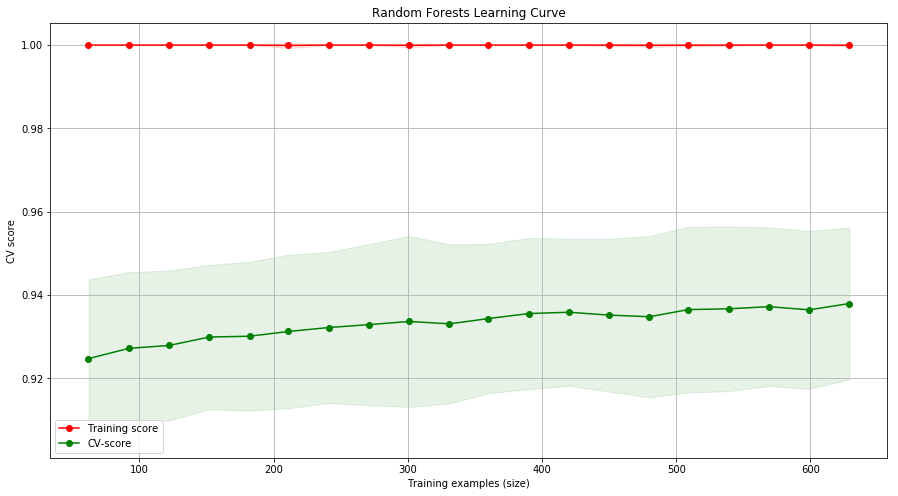

In [19]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=47)
plot_learning_curve(RandomForestClassifier(n_estimators=100),
                   X_train, y_train, cv=cv, n_jobs=4)
plt.title('Random Forests Learning Curve')

Text(0.5, 1.0, 'Logistic Regression Learning Curve')

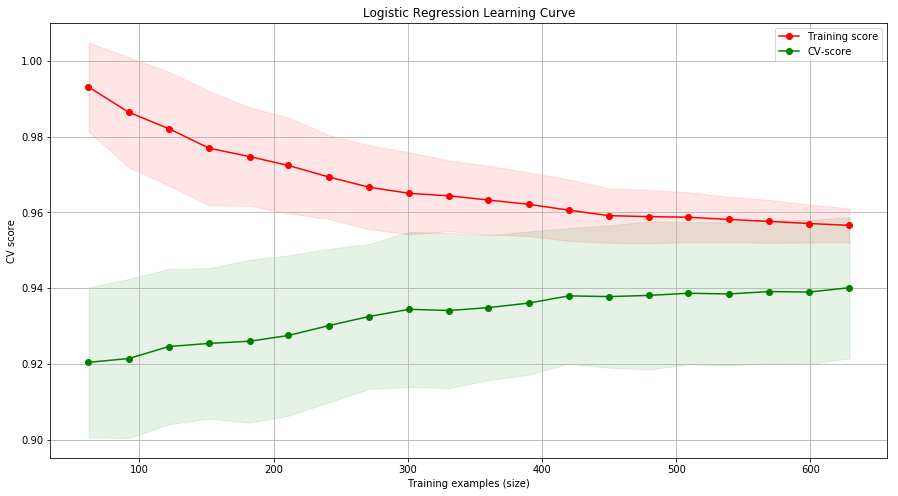

In [20]:
plot_learning_curve(LogisticRegression(solver='lbfgs'),
                   X_train, y_train, cv=cv, n_jobs=4)
plt.title('Logistic Regression Learning Curve')

Text(0.5, 1.0, 'Bagging Learning Curve')

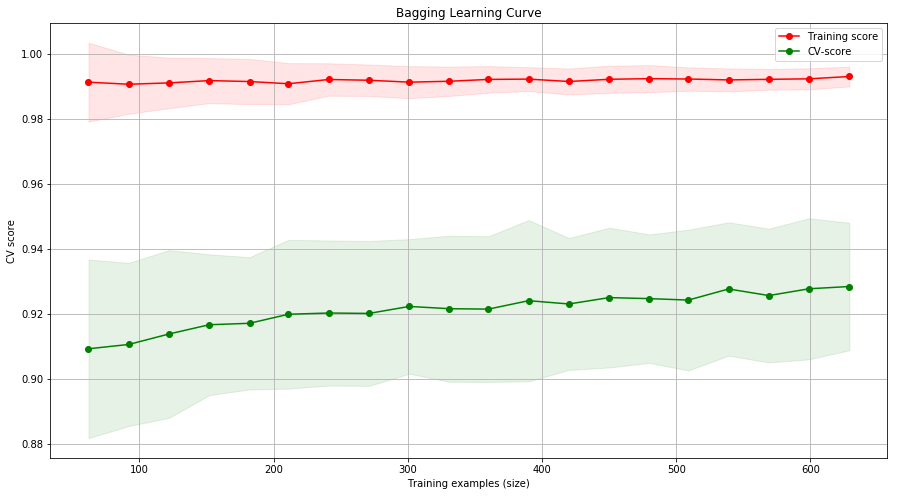

In [21]:
plot_learning_curve(BaggingClassifier(),
                   X_train, y_train, cv=cv, n_jobs=4)
plt.title('Bagging Learning Curve')

Text(0.5, 1.0, 'AdaBoost Learning Curve')

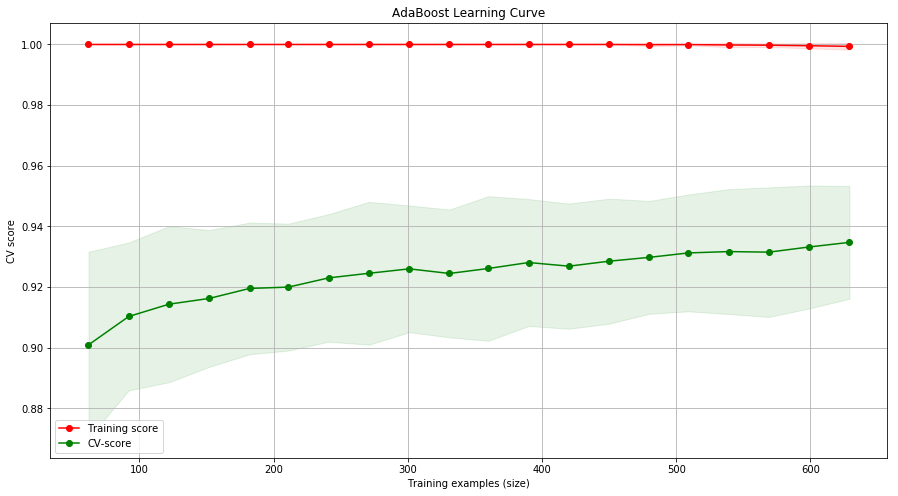

In [22]:
plot_learning_curve(AdaBoostClassifier(),
                   X_train, y_train, cv=cv, n_jobs=4)
plt.title('AdaBoost Learning Curve')

Text(0.5, 1.0, 'SVC Learning Curve')

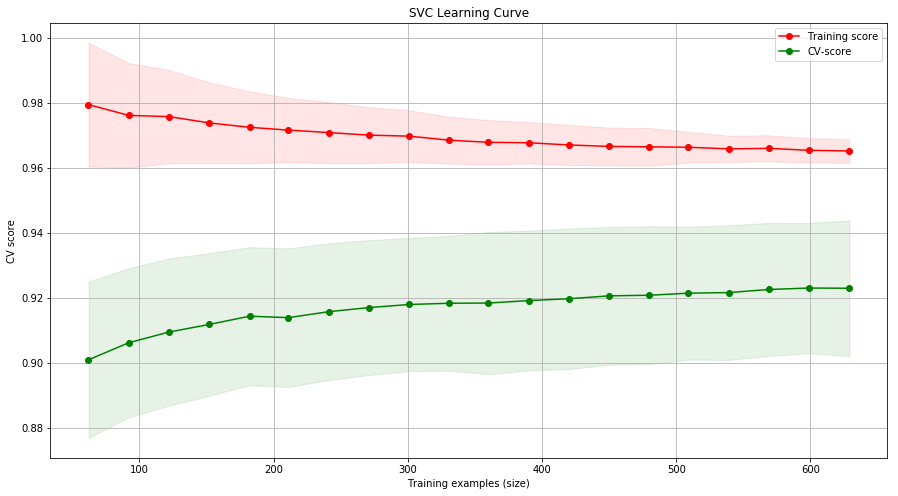

In [23]:
plot_learning_curve(SVC(gamma='auto'),
                   X_train, y_train, cv=cv, n_jobs=4)
plt.title('SVC Learning Curve')

Text(0.5, 1.0, 'Decision Tree Learning Curve')

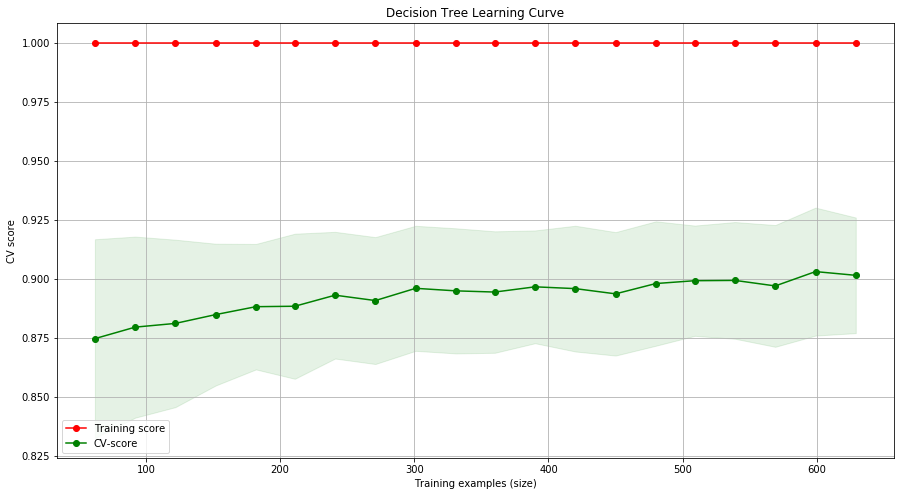

In [24]:
plot_learning_curve(DecisionTreeClassifier(),
                   X_train, y_train, cv=cv, n_jobs=4)
plt.title('Decision Tree Learning Curve')

### Model metrics for the undersampled dataset 

We need to compare the model in two different settings:

* How the model performs in an undersampled data trained setting
* How the model performs in an oversample data trained setting 

The first instance here will be to go for the undersampled dataset. The learning models will be trained on the basis of the undersampled dataset and the classification metrics will be used to determine the classifier which is good at detecting fraudulent transactions.

**Important point to consider**: **Imbalanced datasets should refrain from using % classification accuracy** since the class imbalance will make the accuracy scores always favor the majority class (*in this problem, the majority class being the non-fraud transactions*). Accuracy scores will always be very high, but that would not be a true representation of the model's accuracy since the learning function will generalize extremely well on the basis of the majority sample data which is present in the dataset.


**So how can the performance of such classifiers be measured accurately in an imbalanced setting?**

The problem being addressed is of *detecting frauds*, which means we are supposed to detect the **true positives** of the transactions, or the number of fraud transactions the model is accurately detecting. On the basis of this, what needs to be focused upon more is **Precision and Recall**

* **Precision** : How precise the model is in terms of the true positives. For this fraud transcations problem, precision score will measure the accuracy rate of the classifier in classifying a fraud transaction given that it actually detects a transaction to be fraud. 

* **Recall**: How many fraud transactions is the model able to detect accurately.

In [26]:
#Fitting the models for training and obtaining the P-R scores
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, classification_report, roc_curve, f1_score
, 
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(original_Xtest)
    acc = accuracy_score(original_ytest, prediction)
    f1 = f1_score(original_ytest, prediction)
    cf_matrix = confusion_matrix(original_ytest, prediction)
    #precision = cf_matrix[1, 1:]/(cf_matrix[1, 1:] + cf_matrix[1, :1])
    #recall = cf_matrix[1, 1:]/(cf_matrix[1, 1:] + cf_matrix[0, :1])
    report = classification_report(original_ytest, prediction)
    print('Model accuracy: {}'.format(acc))
    print('F1 score: {}'.format(f1))
    print('Classification report for {}'.format(key))
    print(report)
    print('--------------------------------------------------------------')
    

Model accuracy: 0.9762648783399459
F1 score: 0.12435233160621761
Classification report for Random Forests
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.98      0.12        98

   micro avg       0.98      0.98      0.98     56962
   macro avg       0.53      0.98      0.56     56962
weighted avg       1.00      0.98      0.99     56962

--------------------------------------------------------------
Model accuracy: 0.9647659843404375
F1 score: 0.08731241473396999
Classification report for Bagging Classifier
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.05      0.98      0.09        98

   micro avg       0.96      0.96      0.96     56962
   macro avg       0.52      0.97      0.53     56962
weighted avg       1.00      0.96      0.98     56962

--------------------------------------------------------------
Mode

Looking at the above reports generated, it is very clear that the models have a **very high recall score** for detecting fraud transactions but have a **very low precision score** for actually pinpointing if the detected fraud transaction is actually fraudulent or not. The ROC curve below shows that even though the classifiers have a very good AUC score, this does not necessarily mean that the models are performing well on undersampled data since the actual goal is to **detect fraud transcations** and **not increase model accuracy**

### ROC Curves and AUC Score

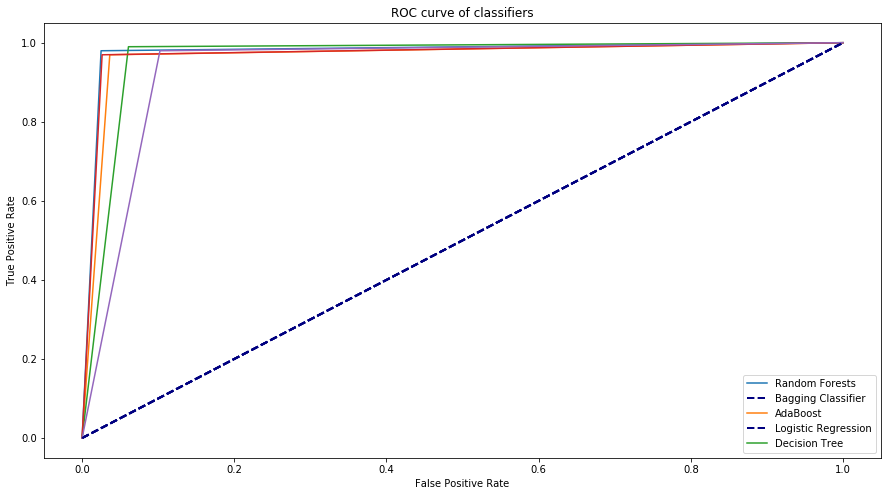

In [27]:
models = []
for key, classifier in classifiers.items():
    name = key
    models.append(name)


plt.figure(figsize=(15,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of classifiers')
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(original_Xtest)
    fpr, tpr, _ = roc_curve(original_ytest, predictions)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle='--')
    plt.legend(models)

In [28]:
from sklearn.metrics import roc_auc_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    preds = classifier.predict(original_Xtest)
    auc_score = roc_auc_score(original_ytest, preds)
    print('AUC score for {}:{}\n'.format(key, auc_score))
    print('------------------------------------')
    
    

AUC score for Random Forests:0.9830627031341519

------------------------------------
AUC score for Bagging Classifier:0.9683302731616

------------------------------------
AUC score for AdaBoost:0.964448113938879

------------------------------------
AUC score for Logistic Regression:0.9715572709106152

------------------------------------
AUC score for Decision Tree:0.949447410506127

------------------------------------


/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


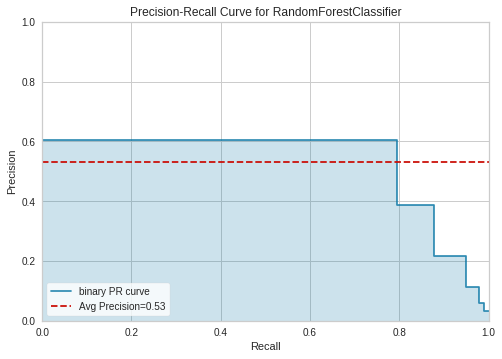

In [29]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(RandomForestClassifier(class_weight='balanced'))
viz.fit(X_train, y_train)
viz.score(original_Xtest, original_ytest)
viz.poof()


### How would the model perform if it was trained with the original sample instead of the undersampled data?

The reports clearly show that the model accuracy is extremely high with high precision and averaging recall scores. The metrics seem very convincing at first that the model performs better on more data, but **this training set contains imbalance**, so the model is generalizing all the training instances as non-fraud transactions

In [30]:
for key, classifier in classifiers.items():
    classifier.fit(original_Xtrain, original_ytrain)
    prediction = classifier.predict(original_Xtest)
    f1 = f1_score(original_ytest, prediction)
    cf_matrix = confusion_matrix(original_ytest, prediction)
    #precision = cf_matrix[1, 1:]/(cf_matrix[1, 1:] + cf_matrix[1, :1])
    #recall = cf_matrix[1, 1:]/(cf_matrix[1, 1:] + cf_matrix[0, :1])
    report = classification_report(original_ytest, prediction)
    acc = accuracy_score(original_ytest, prediction)
    print('Classification report for {}'.format(key))
    print('F1 score: {}'.format(f1))
    print('Accuracy score of {}:{}'.format(key, acc))
    print(report)
    print('--------------------------------------------')
    

Classification report for Random Forests
F1 score: 0.8023255813953488
Accuracy score of Random Forests:0.999403110845827
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.70      0.80        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------
Classification report for Bagging Classifier
F1 score: 0.8351648351648353
Accuracy score of Bagging Classifier:0.9994733330992591
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.78      0.84        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.95      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------
Class

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Classification report for Logistic Regression
F1 score: 0.632258064516129
Accuracy score of Logistic Regression:0.9989993328885924
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.50      0.63        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.75      0.82     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------
Classification report for Decision Tree
F1 score: 0.7326732673267328
Accuracy score of Decision Tree:0.9990519995786665
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.76      0.73        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.86      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------


## Data Oversampling using SMOTE

**SMOTE** or also known as **Synthetic Minority Over-Sampling Technique** is an oversampling technique which creates synthetic datapoints with the help of minority class datapoints in order to increase the size of the minority class and resample it *n* times to make it balanced with the majority class. 

### Understanding SMOTE

**Solving the Class Imbalance**: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

**Location of the synthetic points**: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

**Final Effect**: More information is retained since we didn't have to delete any rows unlike in random undersampling.

**Accuracy & Time Tradeoff**: Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.


One of the important things to ensure when running cross-validation on oversampled data is to make sure that the cross-validation occurs during oversampling **AND NOT** before oversampling since this causes **data leakage** and defeats the whole purpose of using a validation fold to assess the performance of the classifier. 

For example, if the original data had 100 fraud transactions and the data was oversampled using SMOTE to boost the fraud transaction sample size to 1000, the validation fold will have more number of fraud transactions than the actual amount, which would cause bias in cross validation and ruin the metric being obtained through cross validation due to data leakage.

![title](https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401)

Hence to overcome this issue, the data is **oversampled during cross-validation**, which means that only the training folds are oversampled.

![The right way to oversample imbalanced dataset](https://beckernick.github.io/oversampling-modeling/)

![title](https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372)

In [31]:
#Oversampling through SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto', random_state=12)
Xtrain_ovsmpl, ytrain_ovsmpl = sm.fit_resample(original_Xtrain, original_ytrain)
print('------------------------------------------')
print('Original length of original_Xtrain: {}'.format(len(original_Xtrain)))
print('Original length of original_ytrain: {}'.format(len(original_ytrain)))
print('Original length of original_Xtest: {}'.format(len(original_Xtest)))
print('Original length of original_ytest: {}'.format(len(original_ytest)))
print('New length of original_Xtrain after SMOTE: {}'.format(len(Xtrain_ovsmpl)))
print('New length of original_ytrain after SMOTE: {}'.format(len(ytrain_ovsmpl)))
print('------------------------------------------')

------------------------------------------
Original length of original_Xtrain: 227845
Original length of original_ytrain: 227845
Original length of original_Xtest: 56962
Original length of original_ytest: 56962
New length of original_Xtrain after SMOTE: 454902
New length of original_ytrain after SMOTE: 454902
------------------------------------------


In [32]:
for key, classifier in classifiers.items():
    classifier.fit(Xtrain_ovsmpl, ytrain_ovsmpl)
    prediction = classifier.predict(original_Xtest)
    acc = accuracy_score(original_ytest, prediction)
    f1 = f1_score(original_ytest, prediction)
    cf_matrix = confusion_matrix(original_ytest, prediction)
    #precision = cf_matrix[1, 1:]/(cf_matrix[1, 1:] + cf_matrix[1, :1])
    #recall = cf_matrix[1, 1:]/(cf_matrix[1, 1:] + cf_matrix[0, :1])
    report = classification_report(original_ytest, prediction)
    print('Model accuracy: {}'.format(acc))
    print('F1 score: {}'.format(f1))
    print('Classification report for {}'.format(key))
    print(report)
    print('--------------------------------------------')
    

Model accuracy: 0.9994382219725431
F1 score: 0.8315789473684211
Classification report for Random Forests
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.81      0.83        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------
Model accuracy: 0.9986833327481479
F1 score: 0.6666666666666666
Classification report for Bagging Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.59      0.77      0.67        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.80      0.88      0.83     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------
Model accuracy: 0.9763877672834521
F1 scor

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Model accuracy: 0.976335100593378
F1 score: 0.12010443864229767
Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.94      0.12        98

   micro avg       0.98      0.98      0.98     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.98      0.99     56962

--------------------------------------------
Model accuracy: 0.9972788876795057
F1 score: 0.48504983388704326
Classification report for Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.36      0.74      0.49        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.68      0.87      0.74     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------


### How are models performing on new oversampled data (confusion matrix)

To get a better idea of how each model performs in terms of true positives and false positives, a confusion matrix will be a better option to visualize 

In [33]:
dtree = DecisionTreeClassifier()
logreg = LogisticRegression()
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()

dtree.fit(Xtrain_ovsmpl, ytrain_ovsmpl)
logreg.fit(Xtrain_ovsmpl, ytrain_ovsmpl)
rfc.fit(Xtrain_ovsmpl, ytrain_ovsmpl)
ada.fit(Xtrain_ovsmpl, ytrain_ovsmpl)

rfc_predictions = rfc.predict(original_Xtest)
logreg_predictions = logreg.predict(original_Xtest)
ada_predictions = ada.predict(original_Xtest)
dtree_predictions = dtree.predict(original_Xtest)

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Decision Trees')

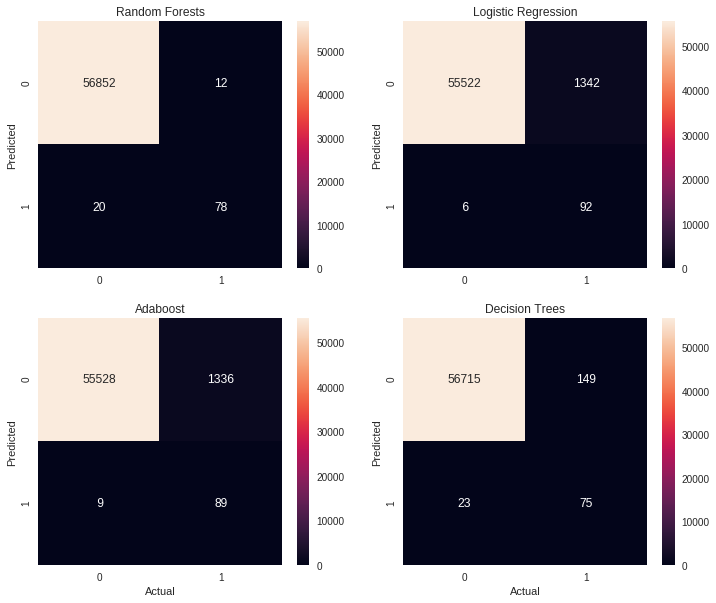

In [34]:
f,ax=plt.subplots(2,2,figsize=(12,10))
#RFC
sns.heatmap(confusion_matrix(original_ytest, rfc_predictions), annot=True, fmt='2.0f', ax=ax[0,0])
ax[0,0].set_ylabel('Predicted')
ax[0,0].set_title('Random Forests')

#Logistic Regression
sns.heatmap(confusion_matrix(original_ytest, logreg_predictions), annot=True, fmt='2.0f', ax=ax[0,1])
ax[0,1].set_ylabel('Predicted')
ax[0,1].set_title('Logistic Regression')

#Adaboost
sns.heatmap(confusion_matrix(original_ytest, ada_predictions), annot=True, fmt='2.0f', ax=ax[1,0])
ax[1,0].set_ylabel('Predicted')
ax[1,0].set_xlabel('Actual')
ax[1,0].set_title('Adaboost')

#Decision Trees
sns.heatmap(confusion_matrix(original_ytest, dtree_predictions), annot=True, fmt='2.0f', ax=ax[1,1])
ax[1,1].set_ylabel('Predicted')
ax[1,1].set_xlabel('Actual')
ax[1,1].set_title('Decision Trees')


As clearly visible, **Random Forests has the best model performance in terms of true positives and true negatives**, with its false positives being the lowest of all. This matters the most for making business decisions since the **cost of flagging fraud transactions as non fraudulent is massive**, which is what logistic regression and adaboost are weak at. 

Though Random Forests has the second highest false negative, the cost of flagging non fraud transactions as fraud is much less compared to vice versa, i.e, flagging fraud transactions as non-fraudulent.

### Average Precision-Recall score for all the models

Since **% accuracy** score will not give the perfect representation of model accuracy, **Average Precision-Recall Score** will be able to give a better idea of how the model is performing.

In [35]:
from sklearn.metrics import average_precision_score

predictions = {
    'Random Forests': rfc_predictions,
    'Logistic Regression': logreg_predictions, 
    'Decision Trees': dtree_predictions,
    'Adaboost': ada_predictions
}

for key, prediction in predictions.items():
    avg_prs = average_precision_score(original_ytest, prediction)
    print('----------------------------------')
    print('Average Precision-Recall score of {}: {}'.format(key, avg_prs))

----------------------------------
Average Precision-Recall score of Random Forests: 0.6901470296345076
----------------------------------
Average Precision-Recall score of Logistic Regression: 0.06033360879073082
----------------------------------
Average Precision-Recall score of Decision Trees: 0.2566446671700626
----------------------------------
Average Precision-Recall score of Adaboost: 0.056878372429692355


## Neural Network Implementation

The next approach here is to apply neural networks since NN's have the power to work well arond noisy data efficiently, and the gradient descent algorithm guarantees that the network will find the optimal parameters which will minimize the cost function.

In [36]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(Xtrain_ovsmpl, ytrain_ovsmpl)
Xtrain_ovsmpl_norm = mms.transform(Xtrain_ovsmpl)

In [37]:
mms.fit(original_Xtest)
original_Xtest_norm = mms.transform(original_Xtest)

In [97]:
from keras import Sequential
from keras.layers import Dense

model = Sequential()

shape = Xtrain_ovsmpl.shape[1]

model.add(Dense(shape, input_shape=(shape, ), activation='softmax'))
model.add(Dense(18, activation='softmax'))
model.add(Dense(12, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

nn_metrics = model.fit(Xtrain_ovsmpl_norm, ytrain_ovsmpl, epochs=30, batch_size=500)

Epoch 1/30
454902/454902 [==============================] - 4s 8us/step - loss: 0.5144 - acc: 0.8104
Epoch 2/30
454902/454902 [==============================] - 3s 6us/step - loss: 0.2025 - acc: 0.9287
Epoch 3/30
454902/454902 [==============================] - 3s 7us/step - loss: 0.1761 - acc: 0.9291
Epoch 4/30
454902/454902 [==============================] - 3s 7us/step - loss: 0.1667 - acc: 0.9316
Epoch 5/30
454902/454902 [==============================] - 3s 7us/step - loss: 0.1605 - acc: 0.9350
Epoch 6/30
454902/454902 [==============================] - 3s 7us/step - loss: 0.1559 - acc: 0.9374
Epoch 7/30
454902/454902 [==============================] - 4s 8us/step - loss: 0.1532 - acc: 0.9386
Epoch 8/30
454902/454902 [==============================] - 3s 7us/step - loss: 0.1512 - acc: 0.9390
Epoch 9/30
454902/454902 [==============================] - 3s 7us/step - loss: 0.1497 - acc: 0.9397
Epoch 10/30
454902/454902 [==============================] - 4s 8us/step - loss: 0.1487 - a

Text(0.5, 1.0, 'Loss curve')

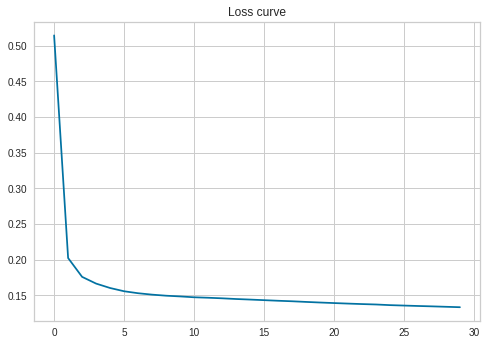

In [110]:
plt.plot(nn_metrics.history['loss'])
plt.title('Loss curve')

Text(0.5, 1.0, 'Accuracy curve')

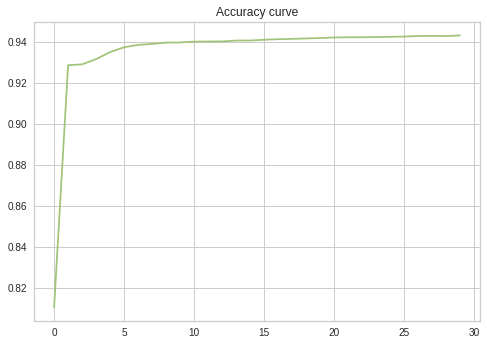

In [111]:
plt.plot(nn_metrics.history['acc'], color='g')
plt.title('Accuracy curve')

In [112]:
undersample_fraud_predictions = model.predict_classes(original_Xtest_norm, verbose=2)

In [113]:
accuracy_score(original_ytest, undersample_fraud_predictions)

0.9990695551420246

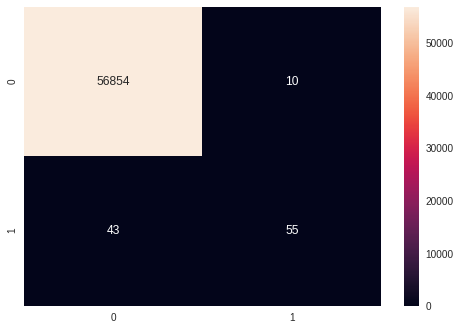

In [114]:
sns.heatmap(confusion_matrix(original_ytest, undersample_fraud_predictions), annot=True, fmt='2.0f')

In [115]:
print(classification_report(original_ytest, undersample_fraud_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.56      0.67        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962



### Conclusion

Implementing oversampling and undersampling techniques on the imbalanced dataset helps with the imbalance of our labels (more no fraud than fraud transactions). Nevertheless, I still have to state that sometimes the neural network on the oversampled dataset predicts less correct fraud transactions than our model using the undersample dataset. However, remember that the removal of outliers was implemented only on the random undersample dataset and not on the oversampled one. Also, in our undersample data our model is unable to detect for a large number of cases non fraud transactions correctly and instead, misclassifies those non fraud transactions as fraud cases. Imagine that people that were making regular purchases got their card blocked due to the reason that our model classified that transaction as a fraud transaction, this will be a huge disadvantage for the financial institution. The number of customer complaints and customer disatisfaction will increase